### Analítica
Vamos a utilizar los datos de ventas de Johnson&Johnson

In [156]:
# librerias
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # corrige este deprecated

import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import ARIMA
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')


In [31]:
data = pd.read_csv('data/jj.csv')
print(len(data))
data.tail(15)

84


,date,data
69,1977-04-02,10.260000
70,1977-07-02,9.540000
71,1977-10-01,8.729999
72,1978-01-01,11.880000
73,1978-04-02,12.060000
74,1978-07-02,12.150000
75,1978-10-01,8.910000
76,1979-01-01,14.040000
77,1979-04-02,12.960000
78,1979-07-02,14.850000


In [70]:
# Piensa cómo lo debes procesar para que la serie temporal funcione

In [32]:
data["date"] = pd.to_datetime(data["date"])
data['date'] = data['date'].apply(lambda x: x.replace(day=1))


In [33]:
data.set_index("date",inplace=True)

In [34]:
data.sort_index(inplace=True)

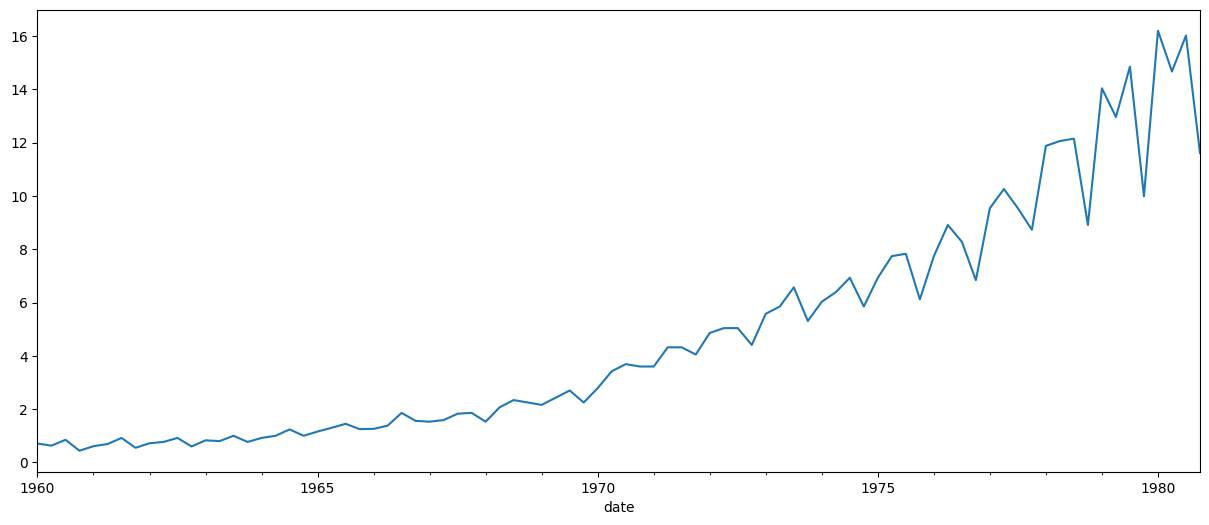

In [35]:
data['data'].plot(figsize=(15,6));

Se aprecia en la gráfica que presenta diferentes estadísticos a lo largo del tiempo.

Representamos su gráfica de autocorrelación. Vemos que tenemos muy complicado determinar el orden p y q, de cara al modelo ARIMA.

* La autocorrelación es importante para determinar si un modelo como ARIMA o SARIMA sería adecuado, ya que revela patrones repetitivos o la estacionalidad

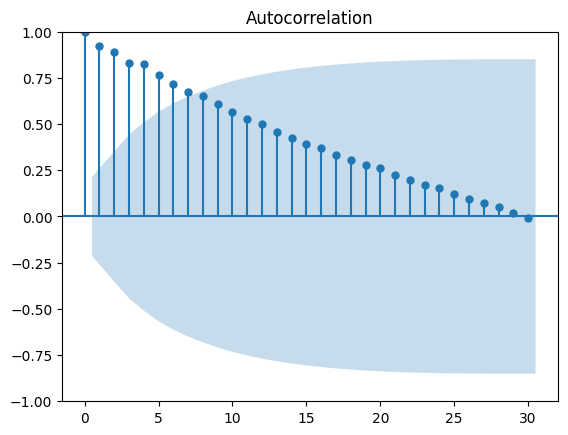

In [36]:
plot_acf(data["data"],lags=30)
plt.show()

Dividimos en train y test

In [37]:
# 18 años para entrenar y 3 para testear, por ejemplo

<Axes: xlabel='date'>

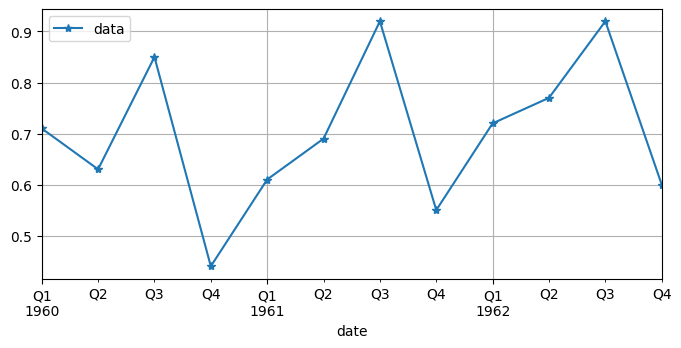

In [38]:
data["1960":"1962"].plot(grid=True, marker="*", figsize=(8, 3.5))

In [39]:
X_train = data["1960":"1978"]
X_test = data["1978":]

In [40]:
#Usar asfreq("Q") ya que los datos son trimestrales
train_series = X_train['data'].asfreq("QS")  # Frecuencia trimestral (Quarterly)
test_series = X_test['data'].asfreq("QS")  # Frecuencia trimestral para el conjunto de validación

In [88]:
# Aplicar la diferenciación trimestral (desplazamiento de 1 trimestre)
diff_QS = X_train[["data"]].diff(1)

# Mostrar resultado
print(diff_QS)

                data
date                
1960-01-01       NaN
1960-04-01 -0.080000
1960-07-01  0.220000
1960-10-01 -0.410000
1961-01-01  0.170000
...              ...
1977-10-01 -0.810001
1978-01-01  3.150001
1978-04-01  0.180000
1978-07-01  0.090000
1978-10-01 -3.240000

[76 rows x 1 columns]


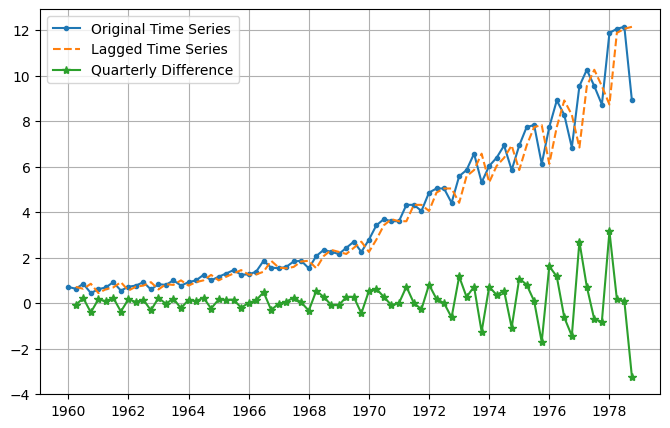

In [89]:
plt.figure(figsize=(8, 5))

# Graficar la serie original
plt.plot(X_train, marker=".", label="Original Time Series")

# Graficar la serie desplazada (lagged)
plt.plot(X_train.shift(1), linestyle="--", label="Lagged Time Series")

# Graficar la diferencia trimestral
plt.plot(diff_QS, marker="*", label="Quarterly Difference")

# Añadir leyenda y cuadrícula
plt.legend()
plt.grid(True)
plt.show()

In [90]:
diff_QS.abs().mean()

data    0.510667
dtype: float64

In [91]:
targets = X_train[["data"]]
((diff_QS / targets).abs().mean())*100

data    15.883563
dtype: float64

- Nuestro predictor "naive" obtiene un MAPE de aproximadamente 16%

## Seasonal Descompose
Tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos.

In [93]:
resul_mult = seasonal_decompose(X_train,model = 'multiplicative', extrapolate_trend = 'freq')
resul_add = seasonal_decompose(X_train,model = 'additive', extrapolate_trend = 'freq')

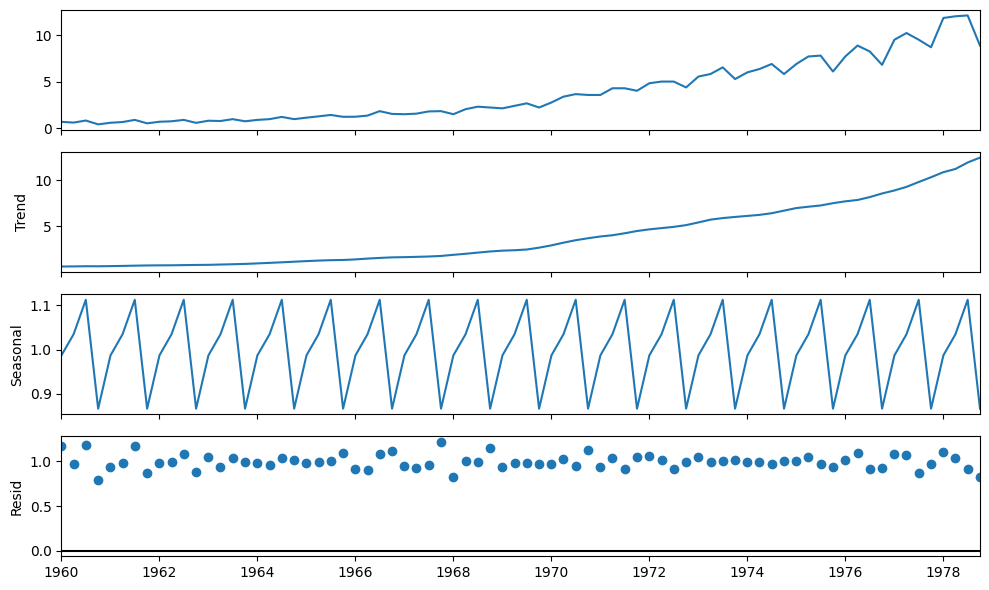

In [99]:
# Plot
plt.rcParams.update({'figure.figsize': (10,6)})
resul_mult.plot();

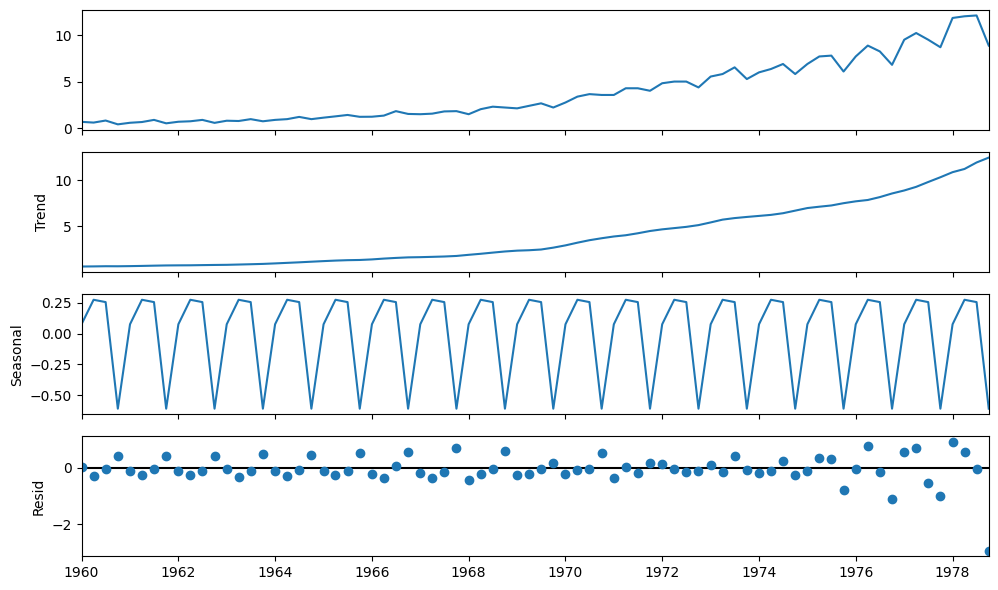

In [98]:
resul_add.plot();

Nuestro predictor "naive" obtiene un MAPE de aproximadamente 16%

## Autoregressive
Tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos.

In [100]:
resultado_adf = adfuller(X_train["data"])
print(f'estadistico adf {resultado_adf[0]}')
print(f'p-valor adf {resultado_adf[1]}')

estadistico adf 2.6788628204415197
p-valor adf 0.9990856104078653


Pero veamos que pasa con la serie temporal si la diferenciamos en 1 Q:

In [113]:

result = adfuller(X_train['data'].diff(1)["1961-01":"1961-12"].values)
result[1]

0.033183043915006656

In [114]:
data["diferencia"] = data[["data"]].diff().dropna()

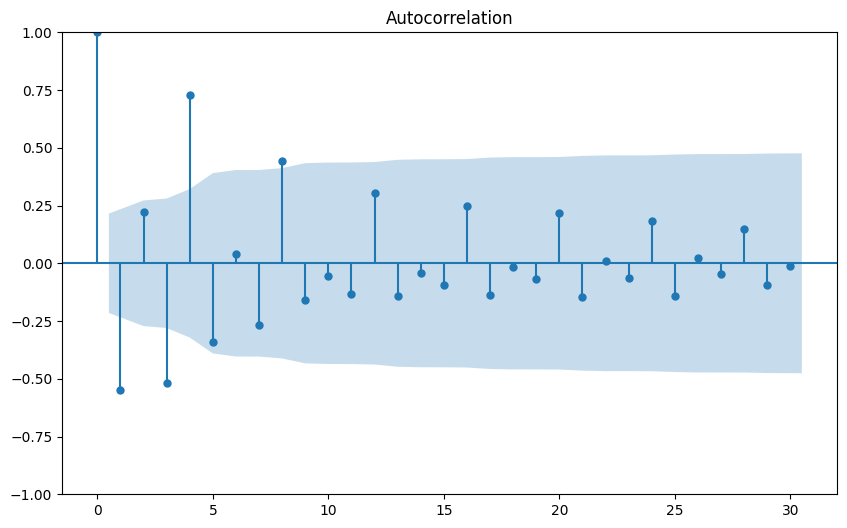

In [115]:
plot_acf(data["diferencia"].dropna(), lags=30)
plt.show()

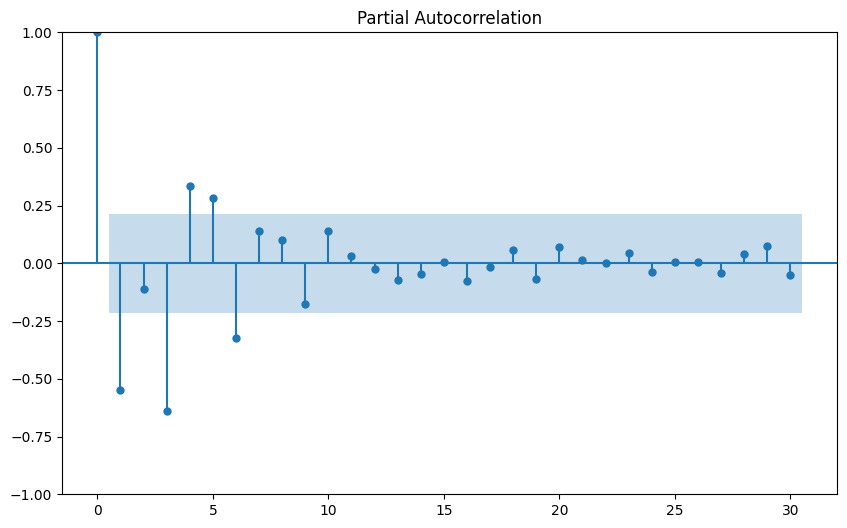

In [116]:
# Autocorrelación parcial para el término AR
plot_pacf(data['diferencia'].dropna(), lags=30)
plt.show()

### Eliminación de tendencias y desestacionalización (Detrending and Deseasonalize)

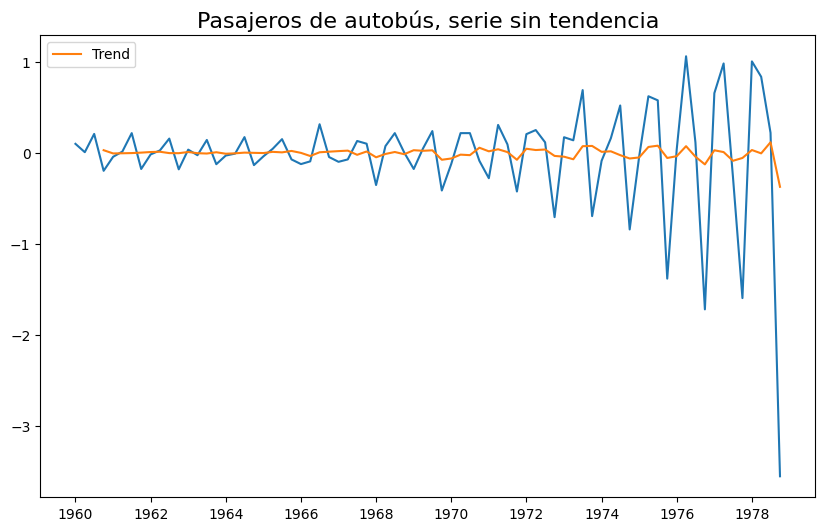

In [135]:
# Quitando la componente de tendencia
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(X_train['data'], model='aditive', extrapolate_trend='freq')
detrended = X_train["data"].values - resul_add.trend
plt.plot(detrended)
plt.plot(detrended.rolling(4).mean(), label = "Trend")
plt.legend()
plt.title('Pasajeros de autobús, serie sin tendencia', fontsize=16);

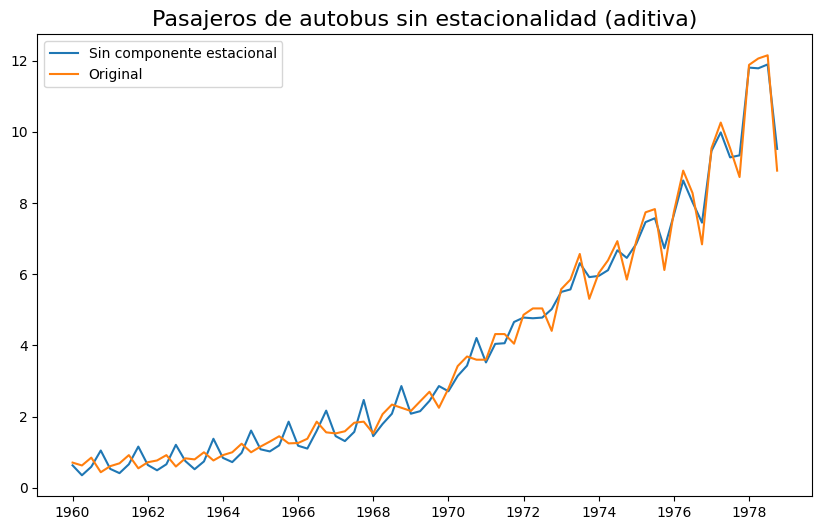

In [140]:
# Deseasonalize
deseasonalized = X_train["data"].values - resul_add.seasonal

# Plot
plt.plot(deseasonalized, label = "Sin componente estacional")
plt.plot(X_train["data"], label = "Original")
plt.legend()
plt.title('Pasajeros de autobus sin estacionalidad (aditiva)', fontsize=16);

#### Aplicando ARIMA

No parece que de buen resultado el AR(1,0,0). Probemos diferentes lags, a ver cuál sería el mejor

In [220]:
#Usar asfreq("Q") ya que los datos son trimestrales
train_series = X_train['data'].asfreq("QS")  # Frecuencia trimestral (Quarterly)
test_series = X_test['data'].asfreq("QS")  # Frecuencia trimestral para el conjunto de validación

In [142]:
model = ARIMA(order=(1, 1, 0)) # (p,d,q) En realidad esto es un AR de grado 1, ya que no hay MA (q=0), ni diferenciación (d=0)
model = model.fit(train_series)
y_pred = model.predict(1) # El argumento es el número de peridos futuros a predecir
y_pred, data.loc[y_pred.index]

(1979-01-01    9.815238
 Freq: QS-JAN, dtype: float64,
              data  diferencia
 1979-01-01  14.04        5.13)

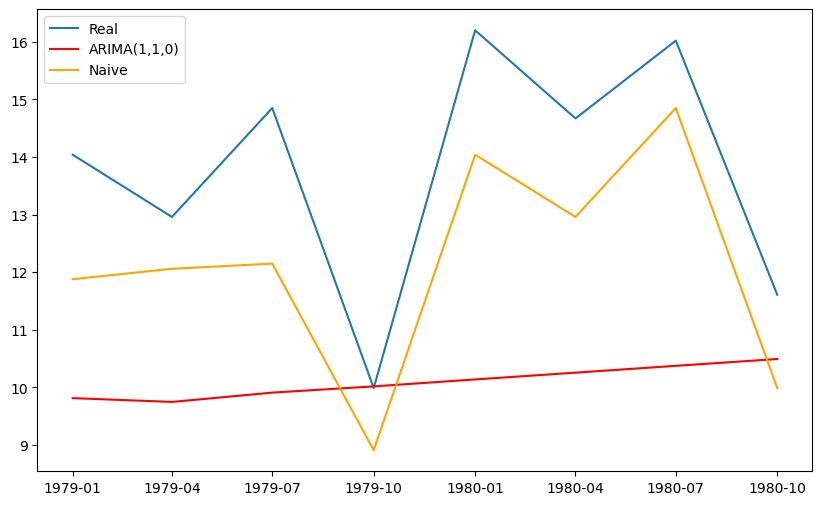

In [152]:
y_pred = model.predict(8) # dos semanas
y_valid = test_series.iloc[4:14]
y_naive = test_series.shift(4).iloc[:14] # Usando el predictor "Naive"
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(1,1,0)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [154]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 4.210982604075186
MAPE: 25.09378834958385


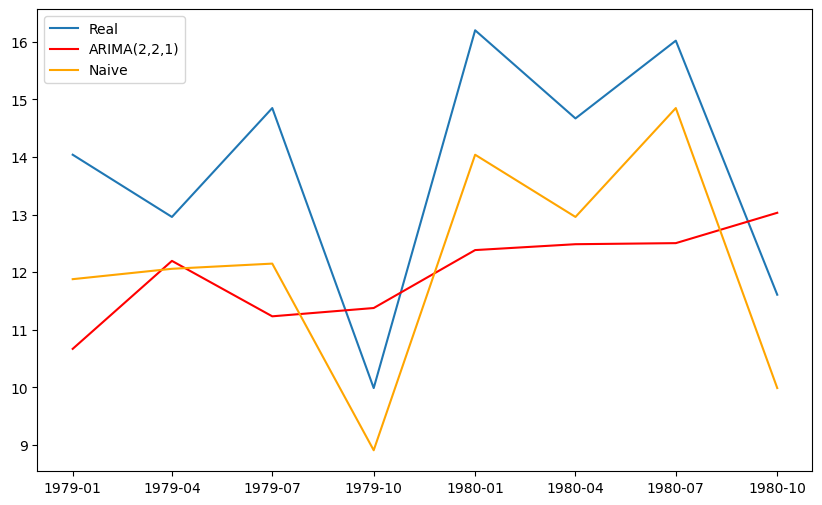

In [157]:
model = ARIMA(order=(2, 2, 1)) # (p,d,q) En realidad esto es un AR de grado 1, ya que no hay MA (q=0), ni diferenciación (d=0)
model = model.fit(train_series)
y_pred = model.predict(8) # dos semanas
y_valid = test_series.iloc[4:14]
y_naive = test_series.shift(4).iloc[:14] # Usando el predictor "Naive"
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(2,2,1)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [158]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 2.7529543968241392
MAPE: 17.594225507234352


### Búsqueda de hiperparámetros

In [159]:
import itertools

p=d=q=range(0,5)
pdq=list(itertools.product(p,d,q))
print("Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones:",len(pdq))
pdq[:10] # Solo los primeros 10 elementos 

Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones: 125


[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [165]:
results = []
for param in pdq:
    try: # Por si alguna combinación "no tiene sentido"
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train_series)
        results.append((param,model_arima_fit.aic())) # obtenemos el AIC por combinación
    except:
        results.append((param,999999999)) # Si no tiene sentido ponemos un código especial
        continue

In [182]:
resultados = pd.DataFrame(results, columns=["Arima Parametros", "AIC"]).sort_values("AIC", ascending=True)

In [183]:
resultados

,Arima Parametros,AIC
111,"(4, 2, 1)",92.945597
87,"(3, 2, 2)",94.066551
88,"(3, 2, 3)",94.098826
112,"(4, 2, 2)",95.075874
86,"(3, 2, 1)",95.359323
...,...,...
1,"(0, 0, 1)",326.674199
70,"(2, 4, 0)",332.845886
45,"(1, 4, 0)",337.870587
20,"(0, 4, 0)",390.206728


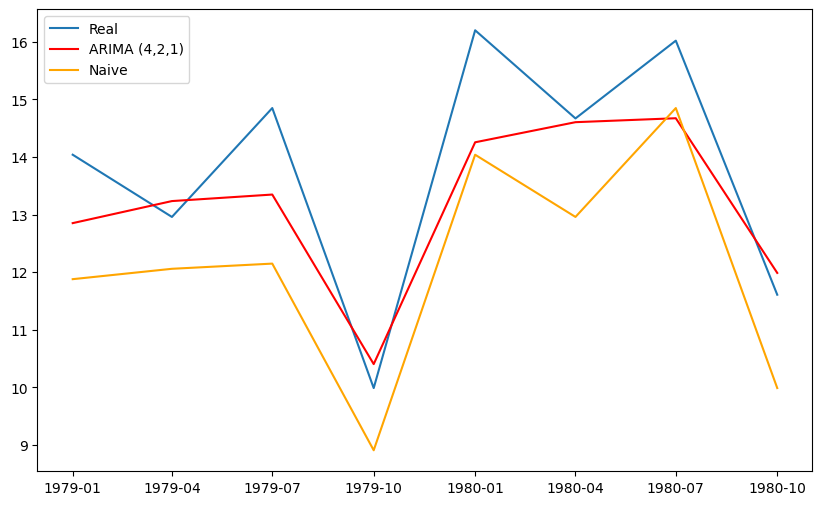

In [191]:
model = ARIMA(order=(4, 2, 2)) # (p,d,q) En realidad esto es un AR de grado 1, ya que no hay MA (q=0), ni diferenciación (d=0)
model = model.fit(train_series)
y_pred = model.predict(8) # dos semanas
y_valid = test_series.iloc[4:14]
y_naive = test_series.shift(4).iloc[:14] # Usando el predictor "Naive"
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA (4,2,1)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [192]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 1.0985061413229442
MAPE: 6.1206698137590765


### SARIMA

RMSE: 0.7882965402622544
MAPE: 5.079151699067919


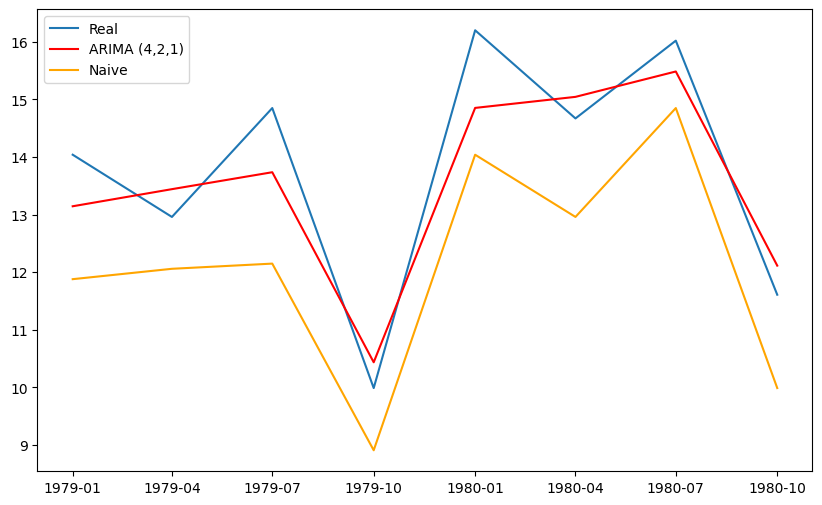

In [226]:
model = ARIMA(order=(4, 2, 1),
        seasonal_order=(0, 1, 1, 4)) # Orden: P,D,Q,s -> s= 7 porque recuerda que era el periodo semanal tan pronunciado
model = model.fit(train_series)

y_pred = model.predict(8) # dos semanas
y_valid = test_series.iloc[4:14]
y_naive = test_series.shift(4).iloc[:14] # Usando el predictor "Naive"
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA (4,2,1)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)


## Sarima

In [228]:
model = auto_arima(train_series,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   m = 4,
                   trace= True,
                   stepwise = False)

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=94.239, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=95.386, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=94.264, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=95.685, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=97.155, Time=0.03 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=95.537, Time=0.01 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=78.391, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=79.569, Time=0.02 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=81.423, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=79.555, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=81.544, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=81.503, Ti

RMSE: 0.7752613709996924
MAPE: 5.30099366970485


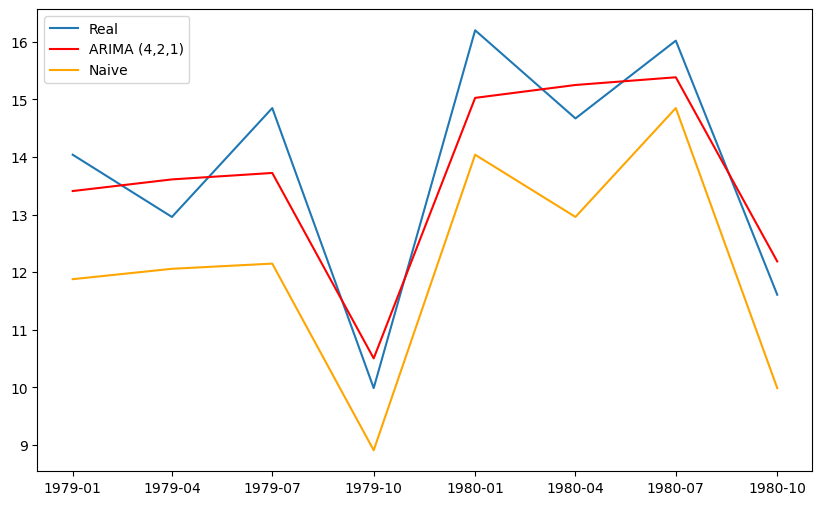

In [229]:
model = ARIMA(order=(0, 1, 1),
        seasonal_order=(0, 1, 0, 4)) # Orden: P,D,Q,s -> s= 7 porque recuerda que era el periodo semanal tan pronunciado
model = model.fit(train_series)

y_pred = model.predict(8) # dos semanas
y_valid = test_series.iloc[4:14]
y_naive = test_series.shift(4).iloc[:14] # Usando el predictor "Naive"
plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA (4,2,1)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

In [ ]:
#Hasta aqui mi ejercicio

## Moving Average
En este caso tendremos en cuenta los errores. El problema es que si tenemos muchos errores al principio, los iremos arrastrando durante las predicciones.

ARIMA(order=(0, 0, 1))

In [30]:
predictions = model_ma.predict(12)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 92.74704974476823


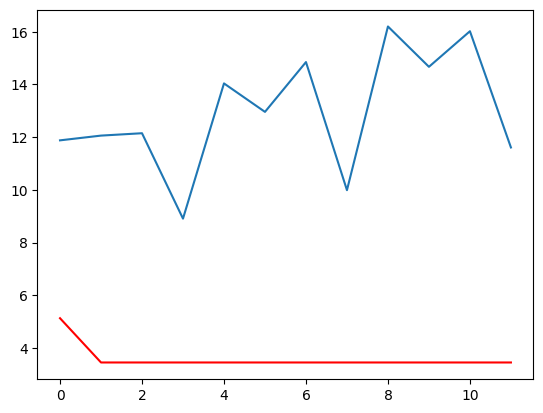

In [31]:
plt.plot(test)
plt.plot(predictions,color='red');

No está dando buen resultado. Probaremos entonces varios lags

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

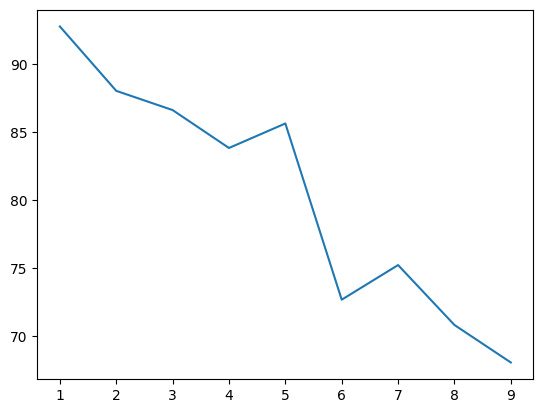

Parece que según vamos aumentando el parámetro `q` del modelo Moving Average, va disminuyendo el error, pero aun así es bastante grande.

## ARIMA
En el arima no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`. Parametro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

### AIC
Akaike’s Information Criterion

![imagen](./img/aic.png)

k es el número de parámetros del modelo estadístico y L es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en terminos absolutos.


#### ¿Cómo conseguir los mejores p, d, q?

In [33]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:6]


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0)]

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

In [35]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
87,"(3, 2, 2)",40.423433
111,"(4, 2, 1)",40.457477
112,"(4, 2, 2)",41.569068
88,"(3, 2, 3)",41.848402
113,"(4, 2, 3)",43.065178


Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [36]:
best_model = ARIMA(order=(3,2,2))
best_model.fit(train)

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(3, 2, 2))

In [37]:
predictions = best_model.predict(12)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 3.433915321870907


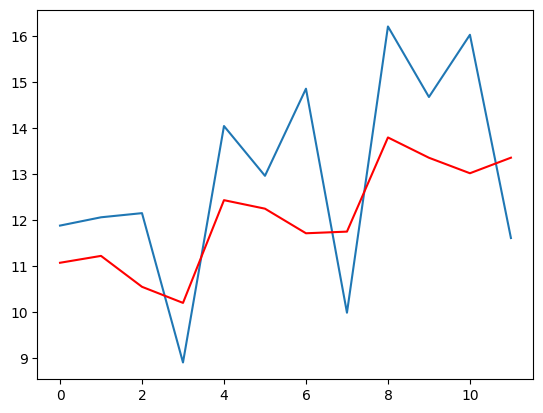

In [38]:
plt.plot(test)
plt.plot(predictions,color='red');

In [39]:
from sklearn.metrics import mean_absolute_percentage_error

print("RMSE:", np.sqrt(mean_squared_error(test, predictions)))
print("MAPE:", mean_absolute_percentage_error(test, predictions) * 100)

RMSE: 1.8530826538152332
MAPE: 12.89204097703901


### Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=202.428, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=191.104, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=176.174, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=122.634, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=49.084, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=46.162, Time=0.64 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=46.808, Time=0.22 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=47.290, Time=0.23 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=45.468, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=90.745, Time=0.09 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=47.187, Time=0.20 sec
 ARIM

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -13.212
Date:                Fri, 27 Sep 2024   AIC                             40.423
Time:                        14:14:40   BIC                             56.163
Sample:                             0   HQIC                            46.675
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0188      0.003      6.263      0.000       0.013       0.025
ar.L1         -1.1071      0.052    -21.260      0.000      -1.209      -1.005
ar.L2         -1.0629      0.049    -21.579      0.0

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# SARIMA añadiendo la estacionalidad de los XXXXX



 ARIMA(0,1,0)(0,1,0)[4]             : AIC=51.280, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=53.242, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=54.563, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=53.250, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=55.132, Time=0.04 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=54.590, Time=0.02 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=40.977, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=41.494, Time=0.04 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=43.487, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=41.514, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=43.489, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=44.749, Time=0.24 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=43.481,

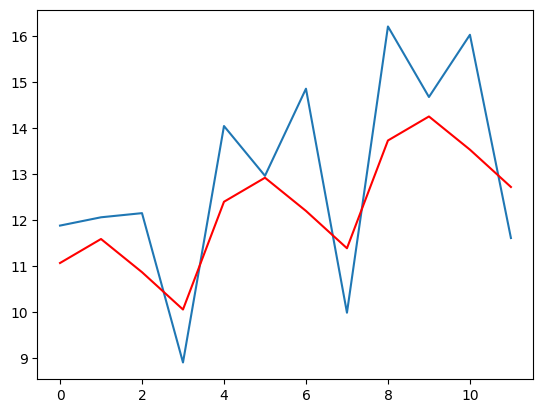

In [43]:
predictions = model.predict(12)
plt.plot(test)
plt.plot(predictions,color='red');

In [44]:
print("RMSE:", np.sqrt(mean_squared_error(test, predictions)))
print("MAPE:", mean_absolute_percentage_error(test, predictions) * 100)

RMSE: 1.5616848071339056
MAPE: 10.108466424976251


## ARIMAX
La X viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Vamos a probar con los datos de la bolsa. Primero un auto_arima con los datos a cierre. Y después un auto_arima acompañado de los datos de apertura de bolsa, a ver cuánto ayudan a predecir el cierre.

In [45]:
stock_df = pd.read_csv('data/FB.csv', header=0, index_col=0)
print(len(stock_df))
stock_df.head()

1259


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600


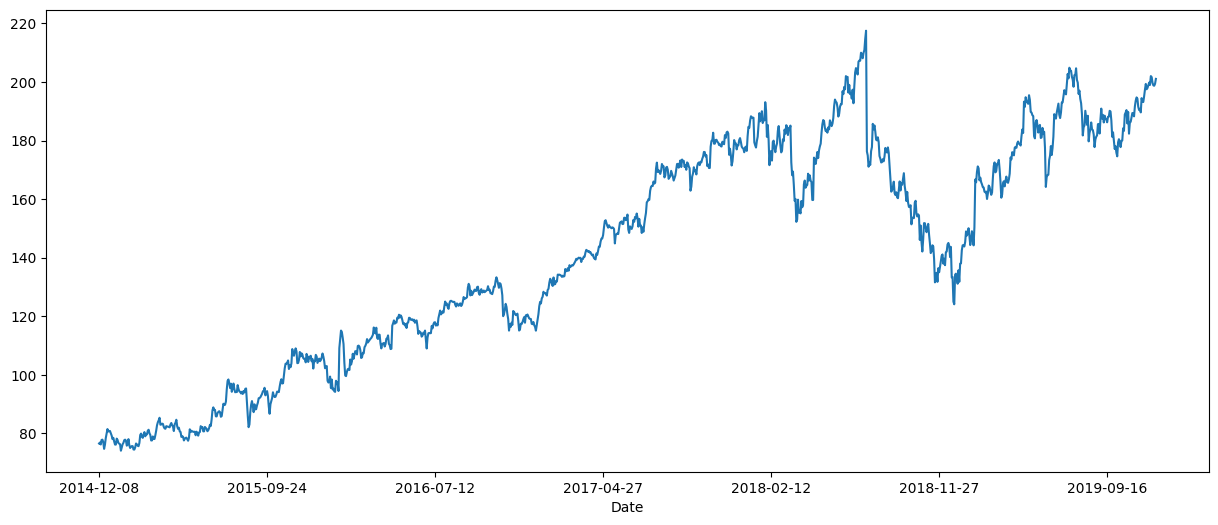

In [46]:
stock_df['Close'].plot(figsize=(15,6));

Vemos primero ejemplo sin variable exógena

In [100]:
# los datos son días
len(stock_df) # 1259 días

1259

In [105]:
1240/1259

0.9849086576648134

In [47]:
train = stock_df['Close'][0:1240].values
test = stock_df['Close'][1240:].values

Vamos a probar varios ARIMAS, a ver cuál sería la mejor combinación de hiperparámetros.

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=5975.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=5977.161, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=5978.841, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=5979.622, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=5981.437, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=5977.785, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=5977.174, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=5973.080, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=5976.192, Time=0.70 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=5978.070, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=5978.892, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=5974.760, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=5976.355, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)

Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Fri, 27 Sep 2024   AIC                           5973.080
Time:                        14:18:27   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.065      0.287      -0.010       0.035
ar.L1          0.8642      0.086     10.019      0.000       0.695       1.033
ma.L1         -0.9007      0.075    -11.983      0.0

In [51]:
predictions = stepwise_model.predict(19)
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 45.03314158782653


Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exogena al entrenamiento

In [52]:
stock_df[['Open']][:1240].values

array([[ 76.18    ],
       [ 75.199997],
       [ 76.650002],
       ...,
       [194.029999],
       [191.910004],
       [190.      ]])

In [53]:
model = ARIMA(order=(1,1,1), seasonal_order=(0,0,0,1))
model.fit(train, XXXXXX = stock_df['Open'][:1240].values.reshape(-1,1))

print(model.summary())

c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Alberto Romero\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: exogeneous. After release 0.14, th

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Fri, 27 Sep 2024   AIC                           5973.080
Time:                        14:22:44   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.065      0.287      -0.010       0.035
ar.L1          0.8642      0.086     10.019      0.000       0.695       1.033
ma.L1         -0.9007      0.075    -11.983      0.0

Reduce bastante el AIC

Probemos a entrenar el auto arima con la variable exogena

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=5975.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=5977.161, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=5978.841, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=5979.622, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=5981.437, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=5977.785, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=5977.174, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=5973.080, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=5976.192, Time=0.82 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=5978.070, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=5978.892, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=5974.760, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=5976.355, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)

Probemos varias variables exogenas

NOTA: para este apartado se utiliza el valor 'Low', que en la vida real no lo tendríamos para realizar la predicción.

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=5975.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=5977.161, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=5978.841, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=5979.622, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=5981.437, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=5977.785, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=5977.174, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=5973.080, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=5976.192, Time=0.64 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=5978.070, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=5978.892, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=5974.760, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=5976.355, Time=0.90 sec
 ARIMA(3,1,0)(0,0,0)

## SARIMA
Veamos cómo podemos predecir con datos que tienen estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo.

In [58]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


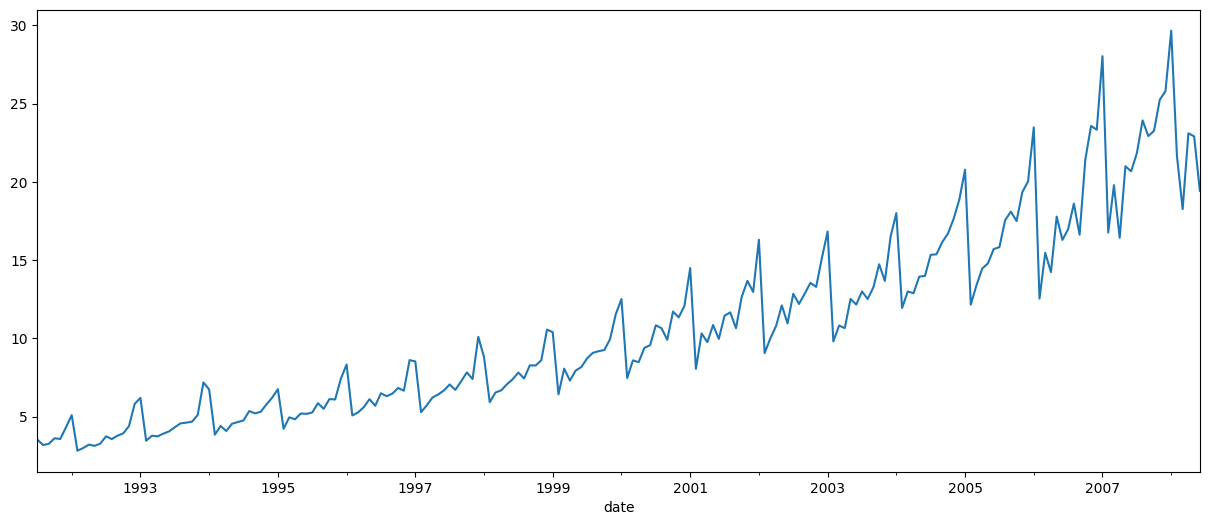

In [59]:
df['value'].plot(figsize=(15,6));

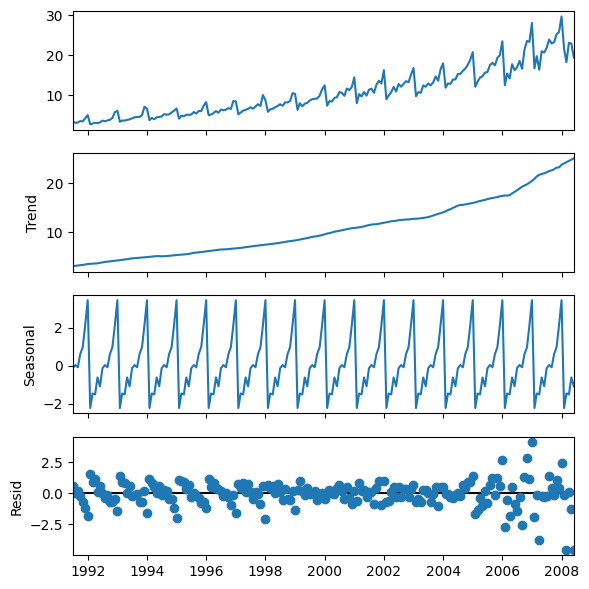

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = XXXXX

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [61]:
X = df[['value']]
train = X[:-20]
test = X[-20:]

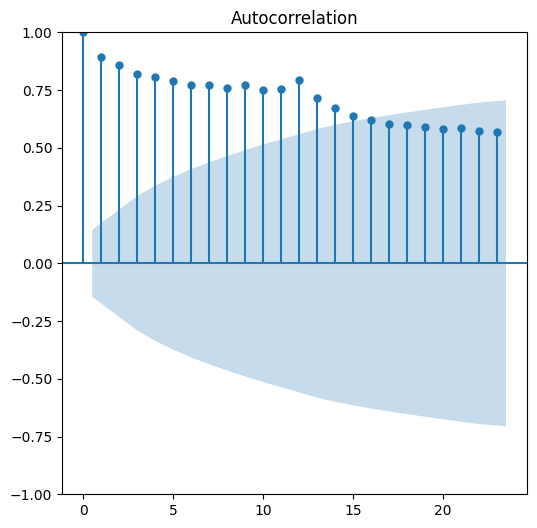

In [62]:
plot_acf(train);

Probemos el auto arima sin indicarle que hay componente de seasonality

Ahora le añadimos el componente seasonality mediante el parametro `m`.